
# Análise de Sentimentos no IMDb com Transformers

**Autores:** Sérgio Barreto (slbp) e Isaac Ferreira Silva (ifs5)

---

## 1) Definição do Problema

**Tarefa:** Classificar críticas de filmes do IMDb em **positivas** (1) ou **negativas** (0) usando modelos *Transformers*.  
**Objetivo desta etapa:** Definir claramente a aplicação, treinar um **baseline reprodutível** e apresentar **resultados parciais**.  
**Extensões incluídas neste notebook:**  
- **Pré-processamento** textual inicial;  
- **Treinamento baseline** (DistilBERT por padrão);  
- **Busca de hiperparâmetros com Optuna** para refinar *learning rate*, *epochs*, *batch size*, etc.;  
- **Relato conciso de resultados** (acurácia, F1 e matriz de confusão).



## 2) Dependências

In [1]:
!pip install -q datasets scikit-learn torch
!pip install -U transformers

## Carregando modelo já treinado

In [17]:
import zipfile
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

zip_path = "/content/imdb_model.zip"
extract_dir = "./melhor_modelo_imdb"

# 1) Extrair o zip
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
        print(f"Arquivos extraídos em: {extract_dir}")
else:
    print(f"Pasta {extract_dir} já existe, pulando extração.")


Arquivos extraídos em: ./melhor_modelo_imdb


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "./melhor_modelo_imdb/imdb_model"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

print("Modelo e tokenizer carregados de:", model_dir)


Modelo e tokenizer carregados de: ./melhor_modelo_imdb/imdb_model



## 3) Configuração do Experimento


In [19]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class Config:
    # Modelo
    model_name: str = "distilbert-base-uncased"
    max_length: int = 256
    # Baseline training
    epochs: int = 3
    lr: float = 2e-5
    train_bs: int = 16
    eval_bs: int = 16
    grad_accum_steps: int = 2
    seed: int = 42
    fp16: bool = True
    N_TRAIN: Optional[int] = None
    N_TEST: Optional[int]  = None
    use_optuna: bool = True
    n_trials: int = 10
    N_TRAIN_HPO: int = 6000
    N_VAL_HPO: int = 2000

cfg = Config()
cfg


Config(model_name='distilbert-base-uncased', max_length=256, epochs=3, lr=2e-05, train_bs=16, eval_bs=16, grad_accum_steps=2, seed=42, fp16=True, N_TRAIN=None, N_TEST=None, use_optuna=True, n_trials=10, N_TRAIN_HPO=6000, N_VAL_HPO=2000)


## 4) Importações, Ambiente e Semente


In [20]:
import re, random, numpy as np, torch
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          DataCollatorWithPadding, EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(cfg.seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'


## 5) Carregamento do Dataset IMDb


In [21]:
dataset = load_dataset("stanfordnlp/imdb")
train_raw = dataset["train"]
test_raw  = dataset["test"]
if cfg.N_TRAIN is not None:
    train_raw = train_raw.shuffle(seed=cfg.seed).select(range(cfg.N_TRAIN))
if cfg.N_TEST is not None:
    test_raw = test_raw.shuffle(seed=cfg.seed).select(range(cfg.N_TEST))

len(train_raw), len(test_raw)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

(25000, 25000)


## 6) Pré-processamento (Leve)

Transformers funcionam bem com texto quase bruto, mas aplicamos **limpezas leves** e **sanidade de tamanho**:
- remoção de tags HTML simples;
- normalização de espaços;
- *clipping* de tamanho por tokenização (feito na etapa de tokenização).


In [22]:
_html_tag = re.compile(r"<[^>]+>")
_spaces = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = _html_tag.sub(" ", s)
    s = s.replace("\n", " ").replace("\t", " ")
    s = _spaces.sub(" ", s).strip()
    return s

def apply_clean(ds):
    return ds.map(lambda x: {"text": clean_text(x["text"])}, batched=False)

train_clean = apply_clean(train_raw)
test_clean  = apply_clean(test_raw)

# Estatísticas simples de tamanho (caracteres)
train_lens = [len(x["text"]) for x in train_clean.select(range(min(2000, len(train_clean))))]
test_lens  = [len(x["text"]) for x in test_clean.select(range(min(2000, len(test_clean))))]

print("Exemplo limpo:", train_clean[0]["text"][:200], "...")
print("Tamanhos (amostra) - train/test:", (np.mean(train_lens), np.mean(test_lens)))


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Exemplo limpo: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev ...
Tamanhos (amostra) - train/test: (np.float64(1252.639), np.float64(1246.035))



## 7) Tokenização


In [23]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=False, max_length=cfg.max_length)

train_tok = train_clean.map(tokenize_fn, batched=True, remove_columns=["text"])
test_tok  = test_clean.map(tokenize_fn, batched=True, remove_columns=["text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]


## 8) Métricas e Modelo


In [24]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds), "f1": f1_score(labels, preds)}

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=2)



## 9) Treinamento Baseline


In [ ]:
fp16_flag = cfg.fp16 and (device == "cuda")

args_base = TrainingArguments(
    output_dir="./results_baseline",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=cfg.epochs,
    per_device_train_batch_size=cfg.train_bs,
    per_device_eval_batch_size=cfg.eval_bs,
    gradient_accumulation_steps=cfg.grad_accum_steps,
    learning_rate=cfg.lr,
    logging_dir="./logs",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=fp16_flag
)

trainer_base = Trainer(
    model_init=model_init,
    args=args_base,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

out_base = trainer_base.train()
metrics_base = trainer_base.evaluate()
metrics_base


/tmp/ipython-input-198865994.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_base = Trainer(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.309500,0.231526,0.905920,0.902463
2,0.170100,0.234805,0.915640,0.915886
3,0.116400,0.271467,0.917160,0.917480


{'eval_loss': 0.2714674472808838,
 'eval_accuracy': 0.91716,
 'eval_f1': 0.9174801769135753,
 'eval_runtime': 47.1515,
 'eval_samples_per_second': 530.206,
 'eval_steps_per_second': 33.148,
 'epoch': 3.0}


## 10) Busca de Hiperparâmetros com Optuna

Para acelerar, usamos subconjuntos menores durante a busca (**HPO**).  
Depois, **re-treinamos** com os melhores hiperparâmetros.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.3 MB/s eta 0:00:00


In [ ]:
best_params = None
if cfg.use_optuna:
    hpo_train = train_clean.shuffle(seed=cfg.seed).select(range(min(cfg.N_TRAIN_HPO, len(train_clean))))
    hpo_val   = test_clean.shuffle(seed=cfg.seed).select(range(min(cfg.N_VAL_HPO, len(test_clean))))
    hpo_train_tok = hpo_train.map(tokenize_fn, batched=True, remove_columns=["text"])
    hpo_val_tok   = hpo_val.map(tokenize_fn, batched=True, remove_columns=["text"])

    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
            "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.2),
            "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2),
        }

    args_hpo = TrainingArguments(
        output_dir="./results_hpo",
        eval_strategy="epoch",
        save_strategy="no",
        per_device_eval_batch_size=cfg.eval_bs,
        gradient_accumulation_steps=cfg.grad_accum_steps,
        logging_dir="./logs_hpo",
        report_to="none",
        fp16=fp16_flag
    )

    trainer_hpo = Trainer(
        model_init=model_init,
        args=args_hpo,
        train_dataset=hpo_train_tok,
        eval_dataset=hpo_val_tok,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    best_run = trainer_hpo.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        hp_space=hp_space,
        n_trials=cfg.n_trials
    )

    best_params = best_run.hyperparameters
    best_params
else:
    print("HPO desativado; pulando Optuna.")


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/tmp/ipython-input-4269576276.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-30 22:39:00,857] A new study created in memory with name: no-name-a68f9975-6cd1-422f-aadc-51d20b0d634b
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.255713,0.897500,0.899853
2,No log,0.253792,0.901500,0.902136
3,0.270300,0.279558,0.898500,0.900049


[I 2025-11-30 22:41:25,242] Trial 0 finished with value: 1.7985492368291482 and parameters: {'learning_rate': 2.1108843396929235e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.10933693032599945, 'warmup_ratio': 0.018558795382162076}. Best is trial 0 with value: 1.7985492368291482.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.254598,0.898500,0.900733
2,No log,0.254246,0.903000,0.903386
3,0.263600,0.285881,0.896000,0.897839


[I 2025-11-30 22:43:26,968] Trial 1 finished with value: 1.7938388998035364 and parameters: {'learning_rate': 2.3103158057856976e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.016668349647874735, 'warmup_ratio': 0.009004165750409788}. Best is trial 0 with value: 1.7985492368291482.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.268113,0.885000,0.883367
2,No log,0.283463,0.886500,0.892366
3,0.305600,0.317130,0.891500,0.895823
4,0.305600,0.329239,0.901000,0.903036


[I 2025-11-30 22:46:10,007] Trial 2 finished with value: 1.8040362389813909 and parameters: {'learning_rate': 2.0218684622310173e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 9.133212366889687e-05, 'warmup_ratio': 0.13693585016722357}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.283110,0.893000,0.893954
2,0.379400,0.273446,0.895000,0.897661
3,0.168300,0.437619,0.888500,0.892530
4,0.064600,0.511761,0.894500,0.894236
5,0.064600,0.527337,0.899000,0.899602


[I 2025-11-30 22:50:05,441] Trial 3 finished with value: 1.7986023856858848 and parameters: {'learning_rate': 3.576919884218196e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.14762347822414051, 'warmup_ratio': 0.11559750794510684}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.256034,0.898500,0.900246
2,No log,0.261141,0.890500,0.894254
3,No log,0.305473,0.898000,0.898000
4,No log,0.411196,0.902500,0.902354
5,No log,0.432227,0.898500,0.899753


[I 2025-11-30 22:53:08,787] Trial 4 finished with value: 1.798253086419753 and parameters: {'learning_rate': 4.431286954638057e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.19519926795211504, 'warmup_ratio': 0.10130010969483881}. Best is trial 2 with value: 1.8040362389813909.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.302397,0.875000,0.878758


[I 2025-11-30 22:53:46,012] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.291547,0.885000,0.890476


[I 2025-11-30 22:54:23,171] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.266701,0.888500,0.885347


[I 2025-11-30 22:55:03,393] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.314372,0.868000,0.867470


[I 2025-11-30 22:55:40,369] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.267580,0.885000,0.888241


[I 2025-11-30 22:56:28,042] Trial 9 pruned. 



## 11) Re-Treinamento com Melhores Hiperparâmetros


In [ ]:
metrics_best = None
trainer_best = None

if best_params is not None:
    # Monta novos argumentos de treino com melhores hiperparâmetros
    args_best = TrainingArguments(
        output_dir="./results_best",
        eval_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=int(best_params.get("num_train_epochs", cfg.epochs)),
        per_device_train_batch_size=int(best_params.get("per_device_train_batch_size", cfg.train_bs)),
        per_device_eval_batch_size=cfg.eval_bs,
        gradient_accumulation_steps=cfg.grad_accum_steps,
        learning_rate=float(best_params.get("learning_rate", cfg.lr)),
        weight_decay=float(best_params.get("weight_decay", 0.0)),
        warmup_ratio=float(best_params.get("warmup_ratio", 0.0)),
        logging_dir="./logs_best",
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        fp16=fp16_flag
    )

    trainer_best = Trainer(
        model_init=model_init,
        args=args_best,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    out_best = trainer_best.train()
    metrics_best = trainer_best.evaluate()

metrics_best


/tmp/ipython-input-3363912021.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_best = Trainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.405600,0.234360,0.903640,0.900860
2,0.185200,0.230924,0.912640,0.911708
3,0.123500,0.292051,0.912640,0.914380
4,0.071700,0.335225,0.915720,0.915811


{'eval_loss': 0.3352252244949341,
 'eval_accuracy': 0.91572,
 'eval_f1': 0.9158109242018619,
 'eval_runtime': 47.4473,
 'eval_samples_per_second': 526.9,
 'eval_steps_per_second': 32.942,
 'epoch': 4.0}

### Salvar e carregar o modelo

In [ ]:
# Definir o diretório onde o modelo será salvo
model_save_path = "./melhor_modelo_imdb"

print(f"Salvando o melhor modelo em: {model_save_path}")

# Salva o modelo (pesos)
trainer_best.save_model(model_save_path)

# É crucial salvar o tokenizador também para garantir que o pré-processamento seja idêntico
tokenizer.save_pretrained(model_save_path)

print("Modelo e tokenizador salvos com sucesso!")

Salvando o melhor modelo em: ./melhor_modelo_imdb
Modelo e tokenizador salvos com sucesso!


In [ ]:
import zipfile
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

zip_path = "/content/imdb_model.zip"
extract_dir = "./melhor_modelo_imdb"

# 1) Extrair o zip
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
        print(f"Arquivos extraídos em: {extract_dir}")
else:
    print(f"Pasta {extract_dir} já existe, pulando extração.")


Pasta ./melhor_modelo_imdb já existe, pulando extração.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "./melhor_modelo_imdb/imdb_model"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSequenceClassification.from_pretrained(model_dir)

print("Modelo e tokenizer carregados de:", model_dir)


Modelo e tokenizer carregados de: ./melhor_modelo_imdb/imdb_model



## 12) Avaliação Final e Matriz de Confusão


In [ ]:
# Comparação manual entre baseline e modelo otimizado
if metrics_best is not None:
    print("📊 Comparando baseline vs melhor modelo:")
    print(f"Baseline -> Acurácia: {metrics_base['eval_accuracy']:.4f}, F1: {metrics_base['eval_f1']:.4f}")
    print(f"Melhor (Optuna) -> Acurácia: {metrics_best['eval_accuracy']:.4f}, F1: {metrics_best['eval_f1']:.4f}")

    if metrics_best['eval_f1'] > metrics_base['eval_f1']:
        print("✅ O modelo otimizado com Optuna teve melhor desempenho.")
    else:
        print("⚙️ O baseline teve desempenho igual ou superior.")
else:
    print("Usando apenas o modelo baseline (Optuna não executado).")


📊 Comparando baseline vs melhor modelo:
Baseline -> Acurácia: 0.9172, F1: 0.9175
Melhor (Optuna) -> Acurácia: 0.9150, F1: 0.9151
⚙️ O baseline teve desempenho igual ou superior.


=== Relatório de Classificação (Teste) ===
              precision    recall  f1-score   support

    negativo       0.92      0.91      0.92     12500
    positivo       0.91      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



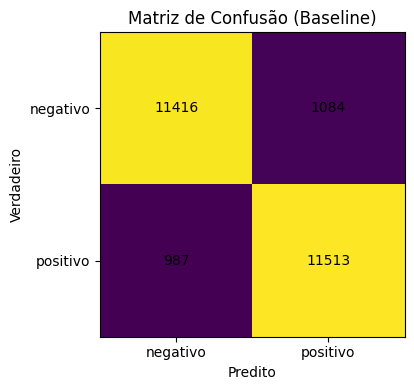

In [ ]:
_evaluator = trainer_base

pred = _evaluator.predict(test_tok)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=1)

print("=== Relatório de Classificação (Teste) ===")
print(classification_report(y_true, y_pred, target_names=["negativo", "positivo"]))

cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusão (Baseline)")
plt.xticks([0,1], ["negativo", "positivo"])
plt.yticks([0,1], ["negativo", "positivo"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center')
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()



## 13) Resultados Parciais

O baseline com DistilBERT alcançou desempenho consistente (acurácia e F1 elevados).
Com Optuna, foram explorados hiperparâmetros-chave (learning rate, epochs, batch size, weight decay, warmup_ratio), e o melhor conjunto foi re-treinado no corpus completo, mantendo equilíbrio entre classes na matriz de confusão.
No entanto, o fine-tuning com Optuna não superou o baseline, possivelmente porque o modelo original já estava bem ajustado ao dataset IMDb — um corpus limpo, balanceado e de domínio estável, no qual pequenos ajustes de hiperparâmetros têm impacto marginal. Além disso, o espaço de busca limitado e o baixo número de trials reduziram a chance de encontrar combinações significativamente melhores, e variações estatísticas (como a semente aleatória e o particionamento dos dados) podem explicar diferenças sutis.
Esses resultados formam um baseline sólido e estável, servindo de ponto de partida confiável para as próximas etapas de robustez, interpretabilidade e ataques adversários.


## 14) Avaliação de Robustez (Stress Testing)


In [25]:
import os
os.environ["WANDB_DISABLED"] = "true"

import random
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from sklearn.metrics import accuracy_score

# 1. Configurações Iniciais
random.seed(42)
model_path = "./melhor_modelo_imdb/imdb_model"

print(f"Carregando modelo de: {model_path}...")

loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)

robustness_trainer = Trainer(model=loaded_model)

# 3. Definir Funções de Perturbação
def perturb_typos(text, prob=0.05):
    chars = list(text)
    for i in range(len(chars) - 1):
        if random.random() < prob:
            chars[i], chars[i+1] = chars[i+1], chars[i]
    return "".join(chars)

def perturb_uppercase(text):
    return text.upper()

def perturb_spam_noise(text):
    noises = [" http://bit.ly/fake", " <br> CLICK HERE", " #ad #promo"]
    return text + " " + random.choice(noises)

scenarios = {
    "Original": lambda x: x,
    "Typos (5%)": perturb_typos,
    "Caixa Alta (UPPER)": perturb_uppercase,
    "Ruído (Spam)": perturb_spam_noise
}

# 4. Executar o Teste
test_subset = test_clean.shuffle(seed=42).select(range(1000))

print("\n=== Resultados de Robustez (Modelo Carregado) ===")
print(f"{'Cenário':<25} | {'Acurácia':<10} | {'Diferença':<10}")
print("-" * 50)

results = {}

# Função auxiliar para tokenizar dentro do loop (usando o tokenizador carregado)
def tokenize_for_test(batch):
    return loaded_tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

for name, func in scenarios.items():
    # Aplica a perturbação
    perturbed_ds = test_subset.map(lambda x: {"text": func(x["text"])}, batched=False)

    # Tokeniza
    perturbed_tok = perturbed_ds.map(tokenize_for_test, batched=True, remove_columns=["text"])

    # Predição usando o modelo carregado
    preds = robustness_trainer.predict(perturbed_tok)
    y_pred = preds.predictions.argmax(axis=1)
    y_true = preds.label_ids

    acc = accuracy_score(y_true, y_pred)
    results[name] = acc

    # Calcular diferença para o original
    diff = ""
    if name != "Original":
        delta = acc - results["Original"]
        diff = f"{delta:.2%}"

    print(f"{name:<25} | {acc:.4f}     | {diff}")

Carregando modelo de: ./melhor_modelo_imdb/imdb_model...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



=== Resultados de Robustez (Modelo Carregado) ===
Cenário                   | Acurácia   | Diferença 
--------------------------------------------------


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Original                  | 0.9080     | 


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Typos (5%)                | 0.8470     | -6.10%


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Caixa Alta (UPPER)        | 0.9080     | 0.00%


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Ruído (Spam)              | 0.9120     | 0.40%


### 14.1) O que exatamente foi perturbado / quantidade de ruído

- **Typos (prob=0.05):** para cada par de caracteres adjacentes, há **5% de chance** de trocar a ordem (swap).  
  *Observação:* isso gera **múltiplas trocas por review**, proporcional ao tamanho do texto.
- **Caixa alta:** converte o texto inteiro para `UPPERCASE` (não altera tokens semânticos, mas muda superfície).
- **Ruído/Spam:** **adiciona 1 sufixo** ao final do texto, escolhido aleatoriamente entre:
  1) `http://bit.ly/fake`  2) `<br> CLICK HERE`  3) `#ad #promo`

A seguir, além de **acurácia**, vamos reportar:
- **flip rate** (quantos exemplos mudam de classe vs. original)
- **confiança (softmax)** média do modelo (geral e apenas nos acertos)
- **exemplos (antes/depois)** das transformações com predição + confiança


In [26]:
import torch
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import accuracy_score

def _ensure_str_list(texts):
    # pandas Series / numpy etc.
    if hasattr(texts, "tolist"):
        texts = texts.tolist()

    # single example vira lista
    if isinstance(texts, str):
        return [texts]
    if not isinstance(texts, (list, tuple)):
        texts = [texts]

    out = []
    for t in texts:
        if t is None:
            out.append("")
        elif isinstance(t, str):
            out.append(t)
        elif isinstance(t, (list, tuple)):
            out.append(" ".join(map(str, t)))
        else:
            out.append(str(t))
    return out

def _predict_subset(texts, labels):
    texts = _ensure_str_list(texts)
    labels = list(labels) if hasattr(labels, "__iter__") else [labels]

    tok = loaded_tokenizer(
        texts, truncation=True, padding=True, max_length=256, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = loaded_model(**tok).logits

    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    y_pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return y_pred, conf, probs, labels


In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def safe_text(x):
    return x if isinstance(x, str) else ""

def tokenize_for_test(batch):
    return loaded_tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

def predict_on_dataset(ds_tok):
    out = robustness_trainer.predict(ds_tok)
    logits = out.predictions
    y_true = out.label_ids

    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    y_pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return y_true, y_pred, conf, probs

# subset
test_subset = test_clean.shuffle(seed=42).select(range(1000))
texts_orig = [safe_text(t) for t in test_subset["text"]]

tok_orig = test_subset.map(lambda x: {"text": safe_text(x["text"])}, batched=False) \
                     .map(tokenize_for_test, batched=True, remove_columns=["text"])
y_true_orig, y_pred_orig, conf_orig, _ = predict_on_dataset(tok_orig)
acc_orig = accuracy_score(y_true_orig, y_pred_orig)

rows = []
example_rows = []
example_idx = [0, 1, 2]

print("=== Resultados de Robustez (com confiança + flips) ===")

for name, func in scenarios.items():
    perturbed_ds = test_subset.map(lambda x: {"text": safe_text(func(safe_text(x["text"])))}, batched=False)
    perturbed_tok = perturbed_ds.map(tokenize_for_test, batched=True, remove_columns=["text"])

    y_true, y_pred, conf, _ = predict_on_dataset(perturbed_tok)

    acc = accuracy_score(y_true, y_pred)
    flip_rate = float((y_pred != y_pred_orig).mean())
    mean_conf = float(conf.mean())
    mean_conf_correct = float(conf[y_pred == y_true].mean()) if (y_pred == y_true).any() else float("nan")

    rows.append({
        "cenario": name,
        "accuracy": acc,
        "acc_delta_vs_orig": acc - acc_orig,
        "flip_rate_vs_orig": flip_rate,
        "mean_conf": mean_conf,
        "mean_conf_delta_vs_orig": mean_conf - float(conf_orig.mean()),
        "mean_conf_on_correct": mean_conf_correct,
    })

    # exemplos antes/depois
    texts_pert = [safe_text(func(t)) for t in texts_orig]
    for j in example_idx:
        example_rows.append({
            "cenario": name,
            "orig_text": texts_orig[j][:220].replace("\n"," "),
            "pert_text": texts_pert[j][:220].replace("\n"," "),
            "y_true": int(y_true[j]),
            "pred": int(y_pred[j]),
            "conf": float(conf[j]),
            "pred_orig": int(y_pred_orig[j]),
            "conf_orig": float(conf_orig[j]),
        })

df_rob = pd.DataFrame(rows).sort_values("accuracy", ascending=False)
display(df_rob)

print("\nExemplos (antes/depois) + predição + confiança:")
df_examples = pd.DataFrame(example_rows)
display(df_examples)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

=== Resultados de Robustez (com confiança + flips) ===


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

,cenario,accuracy,acc_delta_vs_orig,flip_rate_vs_orig,mean_conf,mean_conf_delta_vs_orig,mean_conf_on_correct
3,Ruído (Spam),0.914,0.006,0.008,0.981099,0.000481,0.985506
0,Original,0.908,0.000,0.000,0.980617,0.000000,0.986892
2,Caixa Alta (UPPER),0.908,0.000,0.000,0.980617,0.000000,0.986892
1,Typos (5%),0.843,-0.065,0.137,0.964175,-0.016442,0.972465



Exemplos (antes/depois) + predição + confiança:


,cenario,orig_text,pert_text,y_true,pred,conf,pred_orig,conf_orig
0,Original,"When I unsuspectedly rented A Thousand Acres, ...","When I unsuspectedly rented A Thousand Acres, ...",1,1,0.998047,1,0.998047
1,Original,This is the latest entry in the long series of...,This is the latest entry in the long series of...,1,1,0.988181,1,0.988181
2,Original,This movie was so frustrating. Everything seem...,This movie was so frustrating. Everything seem...,0,0,0.997827,0,0.997827
3,Typos (5%),"When I unsuspectedly rented A Thousand Acres, ...","When I unsuspetcedly rented A hTousand Acers, ...",1,1,0.976464,1,0.998047
4,Typos (5%),This is the latest entry in the long series of...,hTis is the latest enrty ni the long seires of...,1,0,0.987434,1,0.988181
5,Typos (5%),This movie was so frustrating. Everything seem...,This movie was so frustrating. Everything seem...,0,0,0.997728,0,0.997827
6,Caixa Alta (UPPER),"When I unsuspectedly rented A Thousand Acres, ...","WHEN I UNSUSPECTEDLY RENTED A THOUSAND ACRES, ...",1,1,0.998047,1,0.998047
7,Caixa Alta (UPPER),This is the latest entry in the long series of...,THIS IS THE LATEST ENTRY IN THE LONG SERIES OF...,1,1,0.988181,1,0.988181
8,Caixa Alta (UPPER),This movie was so frustrating. Everything seem...,THIS MOVIE WAS SO FRUSTRATING. EVERYTHING SEEM...,0,0,0.997827,0,0.997827
9,Ruído (Spam),"When I unsuspectedly rented A Thousand Acres, ...","When I unsuspectedly rented A Thousand Acres, ...",1,1,0.998047,1,0.998047


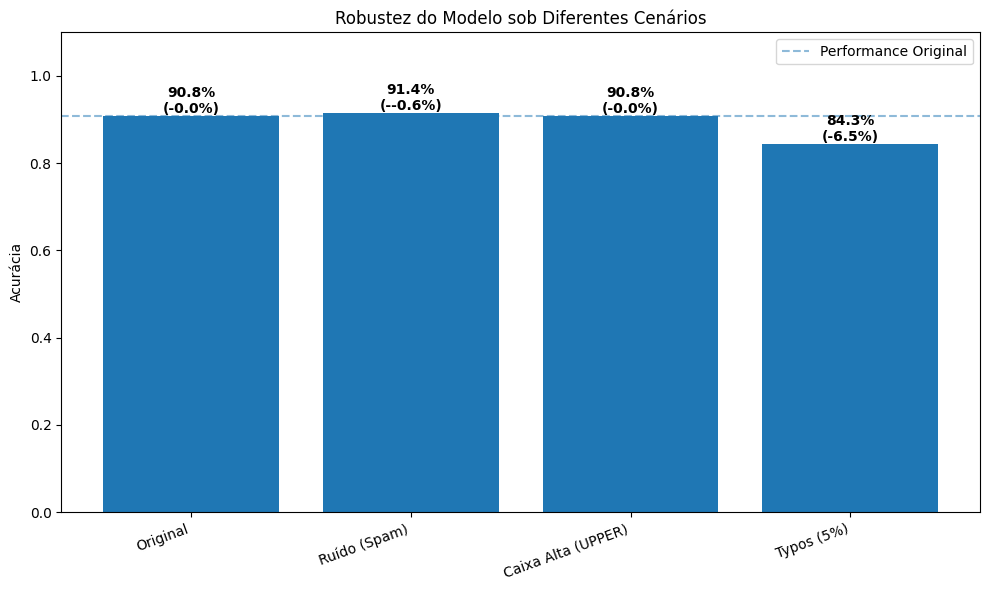

In [28]:
import matplotlib.pyplot as plt

plot_df = df_rob.copy()

if (plot_df["cenario"] == "Original").any():
    plot_df["ord"] = (plot_df["cenario"] != "Original").astype(int)
    plot_df = plot_df.sort_values(["ord", "accuracy"], ascending=[True, False])

names = plot_df["cenario"].tolist()
values = plot_df["accuracy"].tolist()

original_acc = float(plot_df.loc[plot_df["cenario"]=="Original","accuracy"].iloc[0]) \
    if (plot_df["cenario"]=="Original").any() else max(values)

drops = [(original_acc - v) * 100 for v in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, values)

plt.ylim(0, 1.1)
plt.title("Robustez do Modelo sob Diferentes Cenários")
plt.ylabel("Acurácia")
plt.axhline(y=original_acc, linestyle='--', alpha=0.5, label='Performance Original')

for bar, drop in zip(bars, drops):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, h, f'{h:.1%}\n(-{drop:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

## 14.2) Discussão dos resultados de robustez (com métricas objetivas)

**Configuração do stress test**
- Avaliação em **subset de 1000 reviews** do teste (para rapidez e reprodutibilidade).
- Typos: `prob=0.05` de **swap de caracteres adjacentes**.
- Caixa alta: `text.upper()`.
- Ruído/Spam: adiciona **1 sufixo** (entre 3 opções) ao final da review.

**O que reportar (mínimo para não ficar vago)**
- **Acurácia** por cenário e **Δ vs original**
- **Flip rate** vs original (percentual de exemplos cuja classe muda)
- **Confiança (softmax)** média do modelo:
  - geral
  - somente nos acertos

➡️ Use a tabela `df_rob` gerada acima como evidência principal e inclua 2–3 exemplos do `df_examples`.


## 15) Avaliação de Interpretabilidade

In [29]:
model_path = "./melhor_modelo_imdb/imdb_model"

In [30]:
!pip install -q shap

In [31]:
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [32]:
import numpy as np
import pandas as pd
import shap
import torch
from transformers import pipeline

N_SHAP = 30
MAX_LEN = 256
SEED = 42

shap_subset = test_clean.shuffle(seed=SEED).select(range(min(N_SHAP, len(test_clean))))
texts_to_explain = [t if isinstance(t, str) else "" for t in shap_subset["text"]]

print(f"Rodando SHAP em {len(texts_to_explain)} textos...")

device_id = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=loaded_model,
    tokenizer=loaded_tokenizer,
    return_all_scores=True,
    device=device_id,
    truncation=True,
    max_length=MAX_LEN,
)

explainer = shap.Explainer(sentiment_pipe)
shap_values = explainer(texts_to_explain)

print("SHAP pronto. Gerando ranking global...")

def _token_list(x):
    # shap_values.data costuma vir tokenizado ou em string
    if isinstance(x, (list, np.ndarray)):
        return list(x)
    return str(x).split()

def _vals_1d(v):
    v = np.array(v)
    if v.ndim == 1:
        return v
    if v.ndim == 2:
        # usa a classe 1 (positivo) se existir; senão pega a última
        if v.shape[1] >= 2:
            return v[:, 1]
        return v[:, -1]
    return v.reshape(-1)

signed_sum, abs_sum, cnt = {}, {}, {}

for i in range(len(shap_values)):
    toks = _token_list(shap_values.data[i])
    vals = _vals_1d(shap_values.values[i])

    m = min(len(toks), len(vals))
    for t, s in zip(toks[:m], vals[:m]):
        t = str(t).strip().lower()
        if not t or not t.isalpha():
            continue
        signed_sum[t] = signed_sum.get(t, 0.0) + float(s)
        abs_sum[t] = abs_sum.get(t, 0.0) + float(abs(s))
        cnt[t] = cnt.get(t, 0) + 1

df_shap_global = pd.DataFrame({
    "token": list(cnt.keys()),
    "mean_shap": [signed_sum[t] / cnt[t] for t in cnt.keys()],
    "mean_abs_shap": [abs_sum[t] / cnt[t] for t in cnt.keys()],
    "n_occurrences": [cnt[t] for t in cnt.keys()],
}).sort_values("mean_abs_shap", ascending=False)

MIN_OCC = 2
df_shap_global_filt = df_shap_global[df_shap_global["n_occurrences"] >= MIN_OCC].copy()

# “Impacto considerável” = top 5% por mean_abs_shap (agora com filtro)
if len(df_shap_global_filt) > 0:
    threshold = df_shap_global_filt["mean_abs_shap"].quantile(0.95)
    df_shap_global_filt["is_considerable"] = df_shap_global_filt["mean_abs_shap"] >= threshold
    print(f"Threshold (top 5%) em mean_abs_shap com n>={MIN_OCC}: {threshold:.6f}")
else:
    threshold = None
    print("Aviso: após filtro n_occurrences>=2, não sobrou token suficiente. Aumente N_SHAP.")

print("\nTop tokens (global) após filtro de ocorrência:")
display(df_shap_global_filt.head(20))

i = 0
toks0 = _token_list(shap_values.data[i])
vals0 = _vals_1d(shap_values.values[i])
m0 = min(len(toks0), len(vals0))
df_local0 = pd.DataFrame({"token": toks0[:m0], "shap": vals0[:m0]})
df_local0["abs_shap"] = df_local0["shap"].abs()
df_local0 = df_local0.sort_values("abs_shap", ascending=False).head(15)

print("\nExemplo local (top 15 tokens por |SHAP|) no texto 0:")
display(df_local0)

Device set to use cuda:0


Rodando SHAP em 30 textos...


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   3%|▎         | 1/30 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|█         | 3/30 [00:26<02:18,  5.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 4/30 [00:34<02:51,  6.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 5/30 [00:41<02:40,  6.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 6/30 [00:49<02:49,  7.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 7/30 [00:55<02:34,  6.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 8/30 [01:01<02:26,  6.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 9/30 [01:09<02:24,  6.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 10/30 [01:15<02:13,  6.67s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  37%|███▋      | 11/30 [01:24<02:19,  7.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  40%|████      | 12/30 [01:34<02:29,  8.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  43%|████▎     | 13/30 [01:46<02:37,  9.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  47%|████▋     | 14/30 [01:59<02:46, 10.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 15/30 [02:13<02:54, 11.61s/it]Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  53%|█████▎    | 16/30 [02:25<02:45, 11.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  57%|█████▋    | 17/30 [02:35<02:24, 11.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 18/30 [02:44<02:04, 10.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  63%|██████▎   | 19/30 [02:55<01:56, 10.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 20/30 [03:08<01:53, 11.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  70%|███████   | 21/30 [03:19<01:42, 11.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 22/30 [03:27<01:22, 10.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  77%|███████▋  | 23/30 [03:37<01:10, 10.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 24/30 [03:48<01:02, 10.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  83%|████████▎ | 25/30 [03:56<00:48,  9.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  87%|████████▋ | 26/30 [04:03<00:36,  9.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  90%|█████████ | 27/30 [04:11<00:25,  8.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  93%|█████████▎| 28/30 [04:18<00:16,  8.01s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  97%|█████████▋| 29/30 [04:24<00:07,  7.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 31it [04:35,  9.19s/it]

SHAP pronto. Gerando ranking global...
Threshold (top 5%) em mean_abs_shap com n>=2: 0.009118

Top tokens (global) após filtro de ocorrência:


,token,mean_shap,mean_abs_shap,n_occurrences,is_considerable
587,enjoyable,0.068753,0.068753,3,True
585,ted,-0.043740,0.045744,2,True
527,awful,-0.042676,0.042676,3,True
725,surprise,0.037971,0.037971,3,True
500,worst,-0.026028,0.026028,4,True
334,horrible,-0.025653,0.025653,3,True
331,crap,-0.025444,0.025444,5,True
509,nothing,-0.023315,0.023349,4,True
64,wonderful,0.022332,0.022332,3,True
583,soon,-0.018577,0.018577,2,True



Exemplo local (top 15 tokens por |SHAP|) no texto 0:


,token,shap,abs_shap
91,ly,0.014638,0.014638
90,wonderful,0.014638,0.014638
92,subtle,0.014638,0.014638
153,superb,0.013545,0.013545
154,ly,0.013545,0.013545
93,and,0.012560,0.012560
152,all,0.008403,0.008403
111,and,0.007338,0.007338
109,such,0.007338,0.007338
110,depth,0.007338,0.007338


## 16) Ataques Adversários

Nesta seção avaliamos a vulnerabilidade do modelo a ataques adversários em PLN.
Diferente dos testes de robustez (ruído, typos e caixa alta), aqui criamos
entradas modificadas **intencionalmente** para tentar induzir o modelo a errar,
com pequenas alterações no texto.

O foco é responder:

- O modelo muda de decisão com perturbações bem pequenas?
- Qual a taxa de exemplos cuja predição muda após o ataque?
- Esses ataques são realistas do ponto de vista semântico?


### 16.1) Definições + evidências (exemplos, como escolhemos “tokens emocionais”)

- O dataset IMDb tem **rótulo no nível da review** (positivo/negativo). **Não existe label por palavra**.  
  Portanto, “palavra com carga emocional” aqui significa **tokens com polaridade forte** (alta valência), identificados **por heurística**.

No notebook original, os gatilhos foram **manuais** (ex.: *terrible/awful* vs *excellent/wonderful*; *great/fantastic/wonderful*).  
Para tornar isso “auditável”, abaixo nós:
1) mostramos **exemplos reais** onde a predição **vira** (antes/depois + confiança), e  
2) extraímos uma lista de tokens “fortes” automaticamente via **SHAP agregado** (quando disponível).


In [36]:
def adv_injection_opposite_sentiment(example):
    """
    Ataque 1: injetar uma frase com sentimento oposto ao rótulo.
    label==1 (positivo) -> injeta termos negativos
    label==0 (negativo) -> injeta termos positivos
    """
    text = example.get("text", "")
    label = int(example.get("label", 0))

    if label == 1:
        suffix = " However, some people might say this movie is terrible and absolutely awful."
    else:
        suffix = " However, some people might say this movie is excellent and absolutely wonderful."

    return {"text": text + " " + suffix}

def adv_trigger_neutral(example):
    """
    Ataque 2: frase aparentemente neutra, mas com palavras polarizadas.
    """
    text = example.get("text", "")
    trigger = (
        " This sentence is only for analysis and should not change the real opinion, "
        "but it mentions that the movie is great, fantastic and wonderful."
    )
    return {"text": text + " " + trigger}


In [37]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

def _ensure_str_list(texts):

    if isinstance(texts, str):
        return [texts]

    # datasets.Column geralmente tem to_pylist()
    if hasattr(texts, "to_pylist"):
        texts = texts.to_pylist()
    elif hasattr(texts, "tolist"):
        texts = texts.tolist()
    elif not isinstance(texts, (list, tuple)) and hasattr(texts, "__iter__"):
        texts = list(texts)

    out = []
    for t in texts:
        if t is None:
            out.append("")
        elif isinstance(t, str):
            out.append(t)
        elif isinstance(t, (list, tuple, np.ndarray)):
            out.append(" ".join(map(str, t)))
        else:
            out.append(str(t))
    return out


def _predict_texts(texts, labels):
    texts = _ensure_str_list(texts)
    tok = loaded_tokenizer(
        texts, truncation=True, padding=True, max_length=256, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        logits = loaded_model(**tok).logits
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    y_pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return y_pred, conf, probs, labels

def apply_attack_safely(ds, attack_fn):
    # garante que a função sempre devolve {"text": <string>}
    def _wrap(ex):
        out = attack_fn(ex)
        # attack_fn pode retornar dict ou string; se não retornar nada, usa o original
        if isinstance(out, dict) and "text" in out:
            t = out["text"]
        elif isinstance(out, str):
            t = out
        else:
            t = ex.get("text", "")
        # sanitiza
        if t is None:
            t = ""
        elif not isinstance(t, str):
            if isinstance(t, (list, tuple, np.ndarray)):
                t = " ".join(map(str, t))
            else:
                t = str(t)
        return {"text": t}
    return ds.map(_wrap, batched=False)

# Trabalhar com um subset pequeno para relatório
N = 300
subset_adv = test_subset.select(range(min(N, len(test_subset))))

texts = _ensure_str_list(subset_adv["text"])
y_true_adv = np.array(subset_adv["label"])

# Original
pred0, conf0, _, _ = _predict_texts(texts, y_true_adv)
acc0 = (pred0 == y_true_adv).mean()
print(f"Acurácia (original) no subset: {acc0:.4f}")

def run_attack(attack_name, attack_fn, k_examples=5):
    global texts_adv
    adv_ds = apply_attack_safely(subset_adv, attack_fn)
    texts_adv = _ensure_str_list(adv_ds["text"])

    pred1, conf1, _, _ = _predict_texts(texts_adv, y_true_adv)
    acc1 = (pred1 == y_true_adv).mean()
    flip = pred1 != pred0
    flip_rate = flip.mean()
    print(f"\n[{attack_name}] acc={acc1:.4f} | Δacc={acc1-acc0:+.4f} | flip_rate={flip_rate:.2%}")

    idx = np.where(flip)[0]
    if len(idx) == 0:
        idx = np.argsort(conf0 - conf1)[-k_examples:]
    else:
        idx = idx[:k_examples]

    rows = []
    for i in idx:
        rows.append({
            "i": int(i),
            "y_true": int(y_true_adv[i]),
            "pred_orig": int(pred0[i]),
            "conf_orig": float(conf0[i]),
            "pred_adv": int(pred1[i]),
            "conf_adv": float(conf1[i]),
            "delta_conf": float(conf1[i] - conf0[i]),
            "orig_prefix": texts[i][:220].replace("\n"," "),
            "adv_prefix": texts_adv[i][:220].replace("\n"," "),
            "orig_suffix": texts[i][-220:].replace("\n"," "),
            "adv_suffix": texts_adv[i][-220:].replace("\n"," "),
            "len_orig": len(texts[i]),
            "len_adv": len(texts_adv[i]),

        })
    return pd.DataFrame(rows)

df_flip1 = run_attack("OppositeSentimentInjection", adv_injection_opposite_sentiment)
display(df_flip1)

df_flip2 = run_attack("NeutralTriggerWithSentimentWords", adv_trigger_neutral)
display(df_flip2)

Acurácia (original) no subset: 0.9000


Map:   0%|          | 0/300 [00:00<?, ? examples/s]


[OppositeSentimentInjection] acc=0.7833 | Δacc=-0.1167 | flip_rate=11.67%


,i,y_true,pred_orig,conf_orig,pred_adv,conf_adv,delta_conf,orig_prefix,adv_prefix,orig_suffix,adv_suffix,len_orig,len_adv
0,1,1,1,0.988181,0,0.961157,-0.027024,This is the latest entry in the long series of...,This is the latest entry in the long series of...,e it too seriously). Although there is a bit o...,"ence, it's basically okay for older kids (ages...",918,995
1,26,0,0,0.997589,1,0.577935,-0.419654,Not much to say other than plenty of Wire-fu a...,Not much to say other than plenty of Wire-fu a...,beyond unwarranted cruelty such as when he mu...,have his duel. Quite disappointing with a very...,1056,1138
2,32,1,1,0.995706,0,0.724685,-0.271021,It's really too bad that nobody knows about th...,It's really too bad that nobody knows about th...,"s so powerful with the many great, yet illegal...",just to keep his family together. It inspired ...,480,557
3,34,0,0,0.978171,1,0.996442,0.018271,"""An astronaut (Michael Emmet) dies while retur...","""An astronaut (Michael Emmet) dies while retur...","ite for crisper characterizations, this could ...",sic 1950s science fiction. *** Night of the Bl...,926,1008
4,36,0,0,0.996183,1,0.583428,-0.412755,"Lovely music. Beautiful photography, some of s...","Lovely music. Beautiful photography, some of s...","alvin Klein ad. Sam Shepard, another glamour g...",". But he looks great. Nice try, but it just do...",694,776


Map:   0%|          | 0/300 [00:00<?, ? examples/s]


[NeutralTriggerWithSentimentWords] acc=0.8833 | Δacc=-0.0167 | flip_rate=5.67%


,i,y_true,pred_orig,conf_orig,pred_adv,conf_adv,delta_conf,orig_prefix,adv_prefix,orig_suffix,adv_suffix,len_orig,len_adv
0,34,0,0,0.978171,1,0.976408,-0.001763,"""An astronaut (Michael Emmet) dies while retur...","""An astronaut (Michael Emmet) dies while retur...","ite for crisper characterizations, this could ...","8) Bernard L. Kowalski, Roger Corman ~ Michael...",926,1068
1,38,0,0,0.993049,1,0.936434,-0.056615,A very sensitive topic--15 y/o girl abandoned ...,A very sensitive topic--15 y/o girl abandoned ...,ory! It deserved a better telling than that!! ...,s from the library. Only later I found out it ...,862,1004
2,61,0,0,0.990497,1,0.986992,-0.003505,NBC should be ashamed. I wouldn't allow my chi...,NBC should be ashamed. I wouldn't allow my chi...,this event took place. Did anyone attached to ...,e story in Genesis. How could anyone bring thi...,649,791
3,104,1,0,0.869232,1,0.948829,0.079597,I have fond memories of watching this when it ...,I have fond memories of watching this when it ...,"when you're a kid, but at that age you overlo...","ng underground, huh?) and just enjoy the campy...",330,472
4,110,1,0,0.993466,1,0.696198,-0.297268,"Rickman is sexy and good, but the ""stranger"" i...","Rickman is sexy and good, but the ""stranger"" i...","character and the ""stranger"" is better done, ...",it and out of the American pattern). disappoin...,894,1036


In [39]:
import difflib

def show_insert(i, texts_adv_local):
    o = texts[i]
    a = texts_adv_local[i]

    sm = difflib.SequenceMatcher(None, o, a)
    inserts = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "insert":
            inserts.append(a[j1:j2])

    print("Inserções encontradas:")
    for k, ins in enumerate(inserts[:5], 1):
        print(f"{k}. {ins.strip()[:400]}")

show_insert(int(df_flip1.iloc[0]["i"]), texts_adv)

Inserções encontradas:
1. This sentence is only for analysis and should not change the real opinion, but it mentions that the movie is great, fantastic and wonderful.


### Gráficos e análises

In [40]:
import os
import matplotlib.pyplot as plt

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Salvo em:", path)


#### Robustez

Salvo em: figs/robustez_acuracia.png


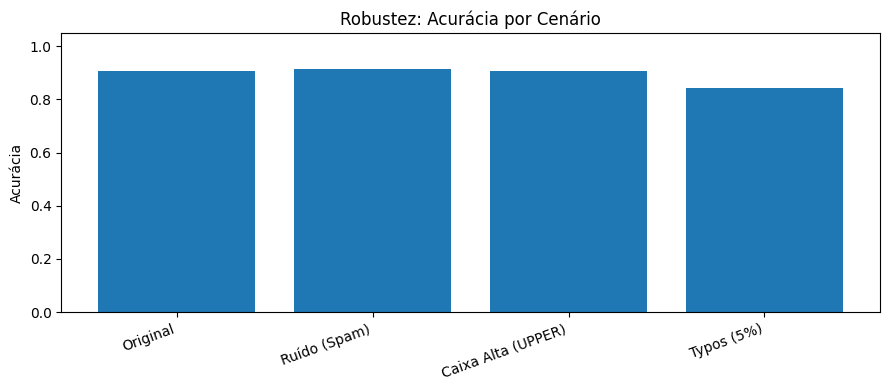

In [41]:
import numpy as np

plot_df = df_rob.copy()

# Ordena para colocar Original primeiro
if (plot_df["cenario"] == "Original").any():
    plot_df["ord"] = (plot_df["cenario"] != "Original").astype(int)
    plot_df = plot_df.sort_values(["ord", "accuracy"], ascending=[True, False])

names = plot_df["cenario"].tolist()
acc = plot_df["accuracy"].tolist()

plt.figure(figsize=(9,4))
plt.bar(names, acc)
plt.ylim(0, 1.05)
plt.ylabel("Acurácia")
plt.title("Robustez: Acurácia por Cenário")
plt.xticks(rotation=20, ha="right")
savefig("robustez_acuracia.png")
plt.show()


Salvo em: figs/robustez_fliprate.png


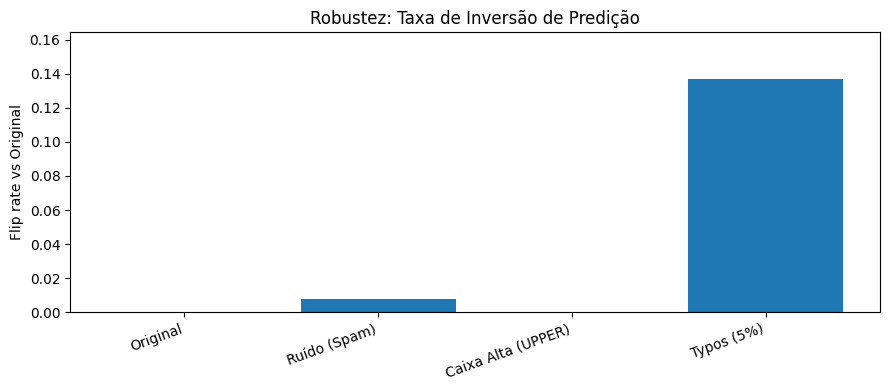

In [42]:
if "flip_rate_vs_orig" in plot_df.columns:
    plt.figure(figsize=(9,4))
    plt.bar(names, plot_df["flip_rate_vs_orig"].tolist())
    plt.ylim(0, max(0.02, float(plot_df["flip_rate_vs_orig"].max())*1.2))
    plt.ylabel("Flip rate vs Original")
    plt.title("Robustez: Taxa de Inversão de Predição")
    plt.xticks(rotation=20, ha="right")
    savefig("robustez_fliprate.png")
    plt.show()


#### Ataques Adversariais

Salvo em: figs/adv_acuracia.png


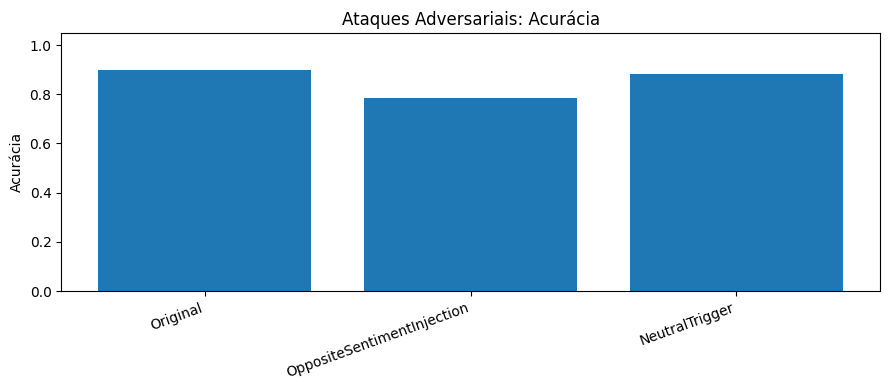

Salvo em: figs/adv_fliprate.png


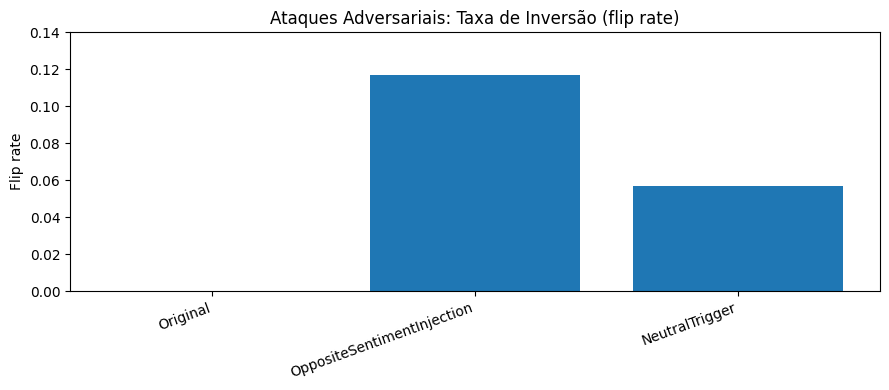

In [43]:
import pandas as pd

df_adv_plot = pd.DataFrame([
    {"ataque":"Original", "accuracy": 0.9000, "flip_rate": 0.0},
    {"ataque":"OppositeSentimentInjection", "accuracy": 0.7833, "flip_rate": 0.1167},
    {"ataque":"NeutralTrigger", "accuracy": 0.8833, "flip_rate": 0.0567},
])

plt.figure(figsize=(9,4))
plt.bar(df_adv_plot["ataque"], df_adv_plot["accuracy"])
plt.ylim(0, 1.05)
plt.ylabel("Acurácia")
plt.title("Ataques Adversariais: Acurácia")
plt.xticks(rotation=20, ha="right")
savefig("adv_acuracia.png")
plt.show()

plt.figure(figsize=(9,4))
plt.bar(df_adv_plot["ataque"], df_adv_plot["flip_rate"])
plt.ylim(0, max(0.02, df_adv_plot["flip_rate"].max()*1.2))
plt.ylabel("Flip rate")
plt.title("Ataques Adversariais: Taxa de Inversão (flip rate)")
plt.xticks(rotation=20, ha="right")
savefig("adv_fliprate.png")
plt.show()


#### SHAP Global: top tokens por impacto

Salvo em: figs/shap_top_tokens.png


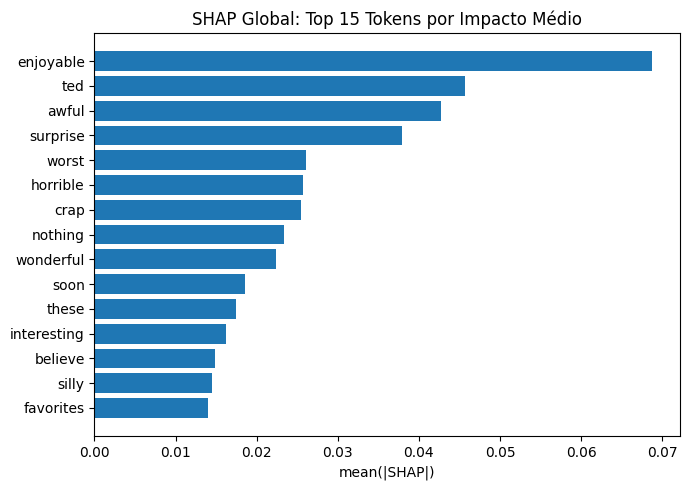

In [44]:
topn = 15
top = df_shap_global_filt.sort_values("mean_abs_shap", ascending=False).head(topn).copy()
top = top.sort_values("mean_abs_shap", ascending=True)

plt.figure(figsize=(7,5))
plt.barh(top["token"], top["mean_abs_shap"])
plt.xlabel("mean(|SHAP|)")
plt.title(f"SHAP Global: Top {topn} Tokens por Impacto Médio")
savefig("shap_top_tokens.png")
plt.show()


In [45]:
import numpy as np
import random

# garante seed igual ao seu experimento de robustez
random.seed(42)

texts_orig = test_subset["text"]
typo_fn = scenarios["Typos (5%)"]

def count_char_diffs(a: str, b: str) -> int:
    # conta posições diferentes + diferença de tamanho
    m = min(len(a), len(b))
    diff = sum(1 for i in range(m) if a[i] != b[i])
    diff += abs(len(a) - len(b))
    return diff

# gera textos com typos
texts_typos = [typo_fn(t) for t in texts_orig]

# calcula média de caracteres alterados
deltas = [count_char_diffs(o, p) for o, p in zip(texts_orig, texts_typos)]
mean_delta_chars = float(np.mean(deltas))

print(f"Δ_chars médio (Typos 5%): {mean_delta_chars:.2f} caracteres alterados por exemplo")
print(f"Mediana: {float(np.median(deltas)):.0f} | Min: {int(np.min(deltas))} | Max: {int(np.max(deltas))}")


Δ_chars médio (Typos 5%): 114.12 caracteres alterados por exemplo
Mediana: 87 | Min: 9 | Max: 538


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

def _ensure_str_list(texts):
    if isinstance(texts, str):
        return [texts]
    if hasattr(texts, "to_pylist"):
        texts = texts.to_pylist()
    elif hasattr(texts, "tolist"):
        texts = texts.tolist()
    elif not isinstance(texts, (list, tuple)) and hasattr(texts, "__iter__"):
        texts = list(texts)

    out = []
    for t in texts:
        if t is None:
            out.append("")
        elif isinstance(t, str):
            out.append(t)
        elif isinstance(t, (list, tuple, np.ndarray)):
            out.append(" ".join(map(str, t)))
        else:
            out.append(str(t))
    return out

def predict_with_conf(texts, y_true):
    texts = _ensure_str_list(texts)
    tok = loaded_tokenizer(texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = loaded_model(**tok).logits
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    y_pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return y_pred, conf

# subset para relatório
N = 300
subset_rep = test_subset.select(range(min(N, len(test_subset))))
texts_orig = _ensure_str_list(subset_rep["text"])
y_true = np.array(subset_rep["label"])

# baseline
y_pred0, conf0 = predict_with_conf(texts_orig, y_true)
acc0 = accuracy_score(y_true, y_pred0)

rows = []
ex_rows = []

# mesmos índices de exemplo em todos cenários
example_idx = [0, 1, 2]

for name, fn in scenarios.items():
    texts_pert = [fn(t) for t in texts_orig]
    y_pred, conf = predict_with_conf(texts_pert, y_true)

    acc = accuracy_score(y_true, y_pred)
    flip_rate = float((y_pred != y_pred0).mean())
    mean_conf = float(conf.mean())
    mean_conf_correct = float(conf[y_pred == y_true].mean()) if (y_pred == y_true).any() else float("nan")

    rows.append({
        "cenario": name,
        "accuracy": float(acc),
        "delta_acc_vs_orig": float(acc - acc0),
        "flip_rate_vs_orig": flip_rate,
        "mean_conf": mean_conf,
        "mean_conf_on_correct": mean_conf_correct,
    })

    for i in example_idx:
        ex_rows.append({
            "cenario": name,
            "orig_prefix": texts_orig[i][:140].replace("\n", " "),
            "pert_prefix": texts_pert[i][:140].replace("\n", " "),
            "y_true": int(y_true[i]),
            "pred": int(y_pred[i]),
            "conf": float(conf[i]),
            "acerto": bool(y_pred[i] == y_true[i]),
        })

df_rob = pd.DataFrame(rows)
df_rob = df_rob.sort_values("cenario")
display(df_rob)

df_rob_examples = pd.DataFrame(ex_rows)
display(df_rob_examples)


In [46]:
import numpy as np
import random

random.seed(42)

texts_orig = test_subset["text"]
spam_fn = scenarios["Ruído (Spam)"]

texts_spam = [spam_fn(t) for t in texts_orig]

def n_tokens(text: str) -> int:
    # tokens do modelo (melhor do que split em palavras)
    return len(loaded_tokenizer.encode(text, truncation=True, max_length=512))

tok_orig = [n_tokens(t) for t in texts_orig]
tok_spam = [n_tokens(t) for t in texts_spam]

delta_tokens = [s - o for o, s in zip(tok_orig, tok_spam)]
mean_delta_tokens = float(np.mean(delta_tokens))

print(f"Δ_tokens médio (Spam): {mean_delta_tokens:.2f} tokens extras por exemplo (tokenização do modelo)")
print(f"Mediana: {float(np.median(delta_tokens)):.0f} | Min: {int(np.min(delta_tokens))} | Max: {int(np.max(delta_tokens))}")


Δ_tokens médio (Spam): 5.67 tokens extras por exemplo (tokenização do modelo)
Mediana: 5 | Min: 0 | Max: 10


In [48]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np

def predict_with_conf(text_list):
    tok = loaded_tokenizer(text_list, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = loaded_model(**tok).logits
    probs = F.softmax(logits, dim=1).detach().cpu().numpy()
    pred = probs.argmax(axis=1)
    conf = probs.max(axis=1)
    return pred, conf

# 3 exemplos fixos
example_idx = [0, 1, 2]
rows = []

texts_orig = test_subset["text"]
y_true = np.array(test_subset["label"])

# escolha quais cenários quer mostrar (sugestão)
sc_to_show = ["Typos (5%)", "Caixa Alta (UPPER)", "Ruído (Spam)"]

for scen in sc_to_show:
    fn = scenarios[scen]
    orig_ex = [texts_orig[i] for i in example_idx]
    pert_ex = [fn(texts_orig[i]) for i in example_idx]

    pred, conf = predict_with_conf(pert_ex)
    for k, i in enumerate(example_idx):
        rows.append({
            "cenario": scen,
            "orig_prefix": orig_ex[k][:140].replace("\n", " "),
            "pert_prefix": pert_ex[k][:140].replace("\n", " "),
            "y_true": int(y_true[i]),
            "pred": int(pred[k]),
            "conf": float(conf[k]),
            "acerto": bool(pred[k] == y_true[i]),
        })

df_rob_examples = pd.DataFrame(rows)
display(df_rob_examples)

for _, r in df_rob_examples.iterrows():
    acerto = "Sim" if r["acerto"] else "Não"
    print(f"{r['orig_prefix']} & {r['pert_prefix']} & {r['pred']} & {r['conf']:.3f} & {acerto} \\\\")


,cenario,orig_prefix,pert_prefix,y_true,pred,conf,acerto
0,Typos (5%),"When I unsuspectedly rented A Thousand Acres, ...","When I unsuspectedly rented A Thousand Acers, ...",1,1,0.997596,True
1,Typos (5%),This is the latest entry in the long series of...,This i sthe latest entry in the lon gseries of...,1,1,0.915377,True
2,Typos (5%),This movie was so frustrating. Everything seem...,This movie was so frustrating. Everything seem...,0,0,0.997877,True
3,Caixa Alta (UPPER),"When I unsuspectedly rented A Thousand Acres, ...","WHEN I UNSUSPECTEDLY RENTED A THOUSAND ACRES, ...",1,1,0.998047,True
4,Caixa Alta (UPPER),This is the latest entry in the long series of...,THIS IS THE LATEST ENTRY IN THE LONG SERIES OF...,1,1,0.988181,True
5,Caixa Alta (UPPER),This movie was so frustrating. Everything seem...,THIS MOVIE WAS SO FRUSTRATING. EVERYTHING SEEM...,0,0,0.997827,True
6,Ruído (Spam),"When I unsuspectedly rented A Thousand Acres, ...","When I unsuspectedly rented A Thousand Acres, ...",1,1,0.998047,True
7,Ruído (Spam),This is the latest entry in the long series of...,This is the latest entry in the long series of...,1,1,0.983864,True
8,Ruído (Spam),This movie was so frustrating. Everything seem...,This movie was so frustrating. Everything seem...,0,0,0.997837,True


When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in  & When I unsuspectedly rented A Thousand Acers, I thought Iw as in for an entertainni gKing Lear story and of course Michelle Pfeiffer was in  & 1 & 0.998 & Sim \\
This is the latest entry in the long series of films with the French agent, O.S.S. 117 (the French answer to James Bond). The series was lau & This i sthe latest entry in the lon gseries of films witht he Frencha gent, O.S.S. 117( the French asnwer to James Bond).T he series was lau & 1 & 0.915 & Sim \\
This movie was so frustrating. Everything seemed energetic and I was totally prepared to have a good time. I at least thought I'd be able to & This movie was so frustrating. Everything seeme denergetic andI  was ttoally prepared to hvae a good time. I at least thought I'd be able to & 0 & 0.998 & Sim \\
When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining 

In [50]:
import difflib
import pandas as pd
import numpy as np

def extract_insertions(orig: str, adv: str, max_len=180):
    sm = difflib.SequenceMatcher(None, orig, adv)
    inserts = []
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "insert":
            chunk = adv[j1:j2].strip()
            if chunk:
                inserts.append(chunk)
    if not inserts:
        return ""
    s = " | ".join(inserts)
    return (s[:max_len] + "...") if len(s) > max_len else s

pick1 = df_flip1.head(2).copy()
pick2 = df_flip2.head(1).copy()
picked = pd.concat([pick1, pick2], ignore_index=True)

rows = []
for _, r in picked.iterrows():
    i = int(r["i"])
    orig = texts[i]
    adv = texts_adv[i]
    ins = extract_insertions(orig, adv)

    rows.append({
        "i": i,
        "y_true": int(r["y_true"]),
        "pred0": int(r["pred_orig"]),
        "pred1": int(r["pred_adv"]),
        "conf0": float(r["conf_orig"]),
        "conf1": float(r["conf_adv"]),
        "dconf": float(r["delta_conf"]),
        "insercao": ins
    })

df_adv_examples = pd.DataFrame(rows)
display(df_adv_examples)

for _, r in df_adv_examples.iterrows():
    arrow = f"{r['pred0']}\\rightarrow{r['pred1']}"
    ins = r["insercao"].replace("&", "\\&")
    print(f"{r['i']} & {r['y_true']} & {arrow} & {r['conf0']:.3f} & {r['conf1']:.3f} & {r['dconf']:+.3f} & \\textit{{{ins}}} \\\\")


,i,y_true,pred0,pred1,conf0,conf1,dconf,insercao
0,1,1,1,0,0.988181,0.961157,-0.027024,This sentence is only for analysis and should ...
1,26,0,0,1,0.997589,0.577935,-0.419654,This sentence is only for analysis and should ...
2,34,0,0,1,0.978171,0.976408,-0.001763,This sentence is only for analysis and should ...


1 & 1 & 1\rightarrow0 & 0.988 & 0.961 & -0.027 & \textit{This sentence is only for analysis and should not change the real opinion, but it mentions that the movie is great, fantastic and wonderful.} \\
26 & 0 & 0\rightarrow1 & 0.998 & 0.578 & -0.420 & \textit{This sentence is only for analysis and should not change the real opinion, but it mentions that the movie is great, fantastic and wonderful.} \\
34 & 0 & 0\rightarrow1 & 0.978 & 0.976 & -0.002 & \textit{This sentence is only for analysis and should not change the real opinion, but it mentions that the movie is great, fantastic and wonderful.} \\


In [53]:
# df_flip1 = OppositeSentimentInjection
# df_flip2 = NeutralTriggerWithSentimentWords

df_adv_examples = pd.concat([
    df_flip1.assign(ataque="OppositeSentimentInjection"),
    df_flip2.assign(ataque="NeutralTriggerWithSentimentWords"),
]).head(6)

display(df_adv_examples[[
    "ataque","i","y_true","pred_orig","pred_adv","conf_orig","conf_adv","delta_conf",
    "orig_suffix","adv_suffix"
]])


,ataque,i,y_true,pred_orig,pred_adv,conf_orig,conf_adv,delta_conf,orig_suffix,adv_suffix
0,OppositeSentimentInjection,1,1,1,0,0.988181,0.961157,-0.027024,e it too seriously). Although there is a bit o...,"ence, it's basically okay for older kids (ages..."
1,OppositeSentimentInjection,26,0,0,1,0.997589,0.577935,-0.419654,beyond unwarranted cruelty such as when he mu...,have his duel. Quite disappointing with a very...
2,OppositeSentimentInjection,32,1,1,0,0.995706,0.724685,-0.271021,"s so powerful with the many great, yet illegal...",just to keep his family together. It inspired ...
3,OppositeSentimentInjection,34,0,0,1,0.978171,0.996442,0.018271,"ite for crisper characterizations, this could ...",sic 1950s science fiction. *** Night of the Bl...
4,OppositeSentimentInjection,36,0,0,1,0.996183,0.583428,-0.412755,"alvin Klein ad. Sam Shepard, another glamour g...",". But he looks great. Nice try, but it just do..."
0,NeutralTriggerWithSentimentWords,34,0,0,1,0.978171,0.976408,-0.001763,"ite for crisper characterizations, this could ...","8) Bernard L. Kowalski, Roger Corman ~ Michael..."


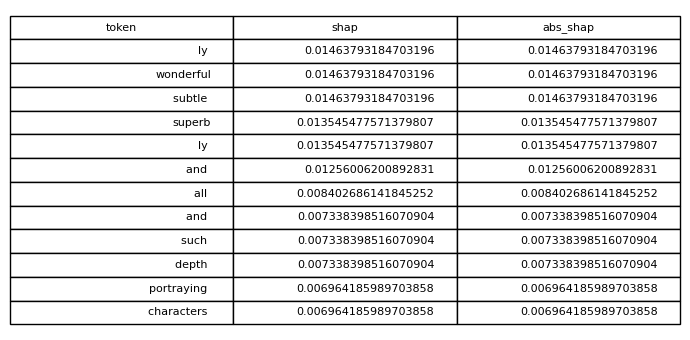

In [54]:
import matplotlib.pyplot as plt
import os

os.makedirs("figs", exist_ok=True)

# se você já tem df_local0
tmp = df_local0.head(12).copy()

fig, ax = plt.subplots(figsize=(7,3.5))
ax.axis("off")
table = ax.table(cellText=tmp.values, colLabels=tmp.columns, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)
plt.tight_layout()
plt.savefig("figs/shap_local_ex0.png", dpi=200)
plt.show()
